Deep Exploration

C:\Users\HP\AppData\Local\Temp\ipykernel_23684\2458723799.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_class, x='count', y='label', palette='viridis')
C:\Users\HP\AppData\Local\Temp\ipykernel_23684\2458723799.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_duration, x='avg_duration', y='label', palette='magma')


EDA plots generated.


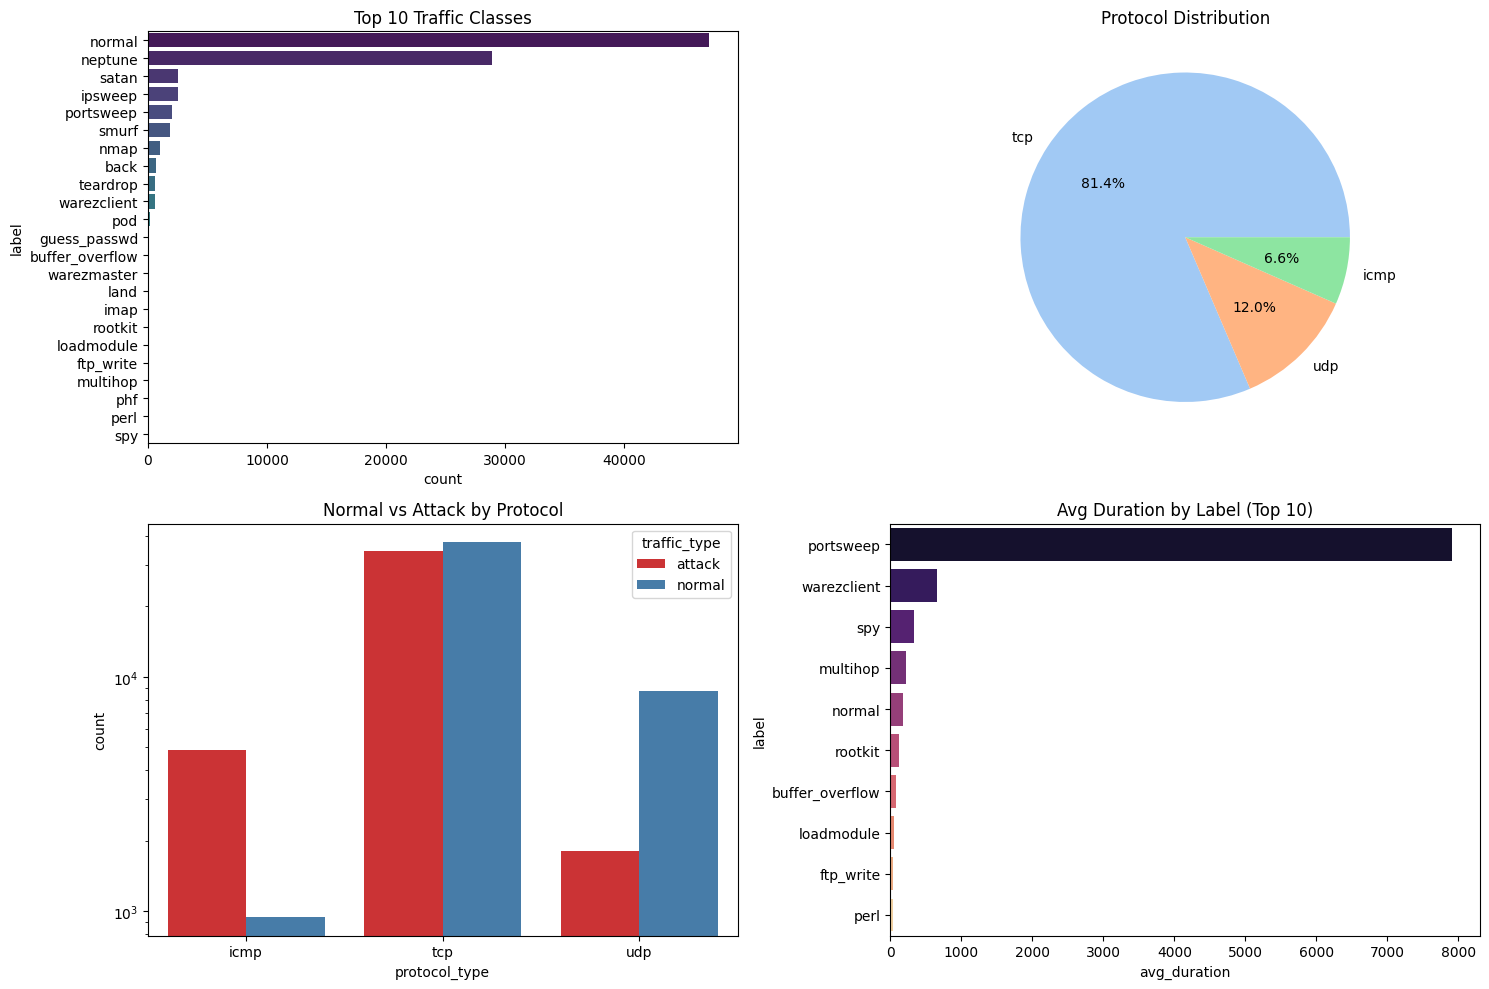

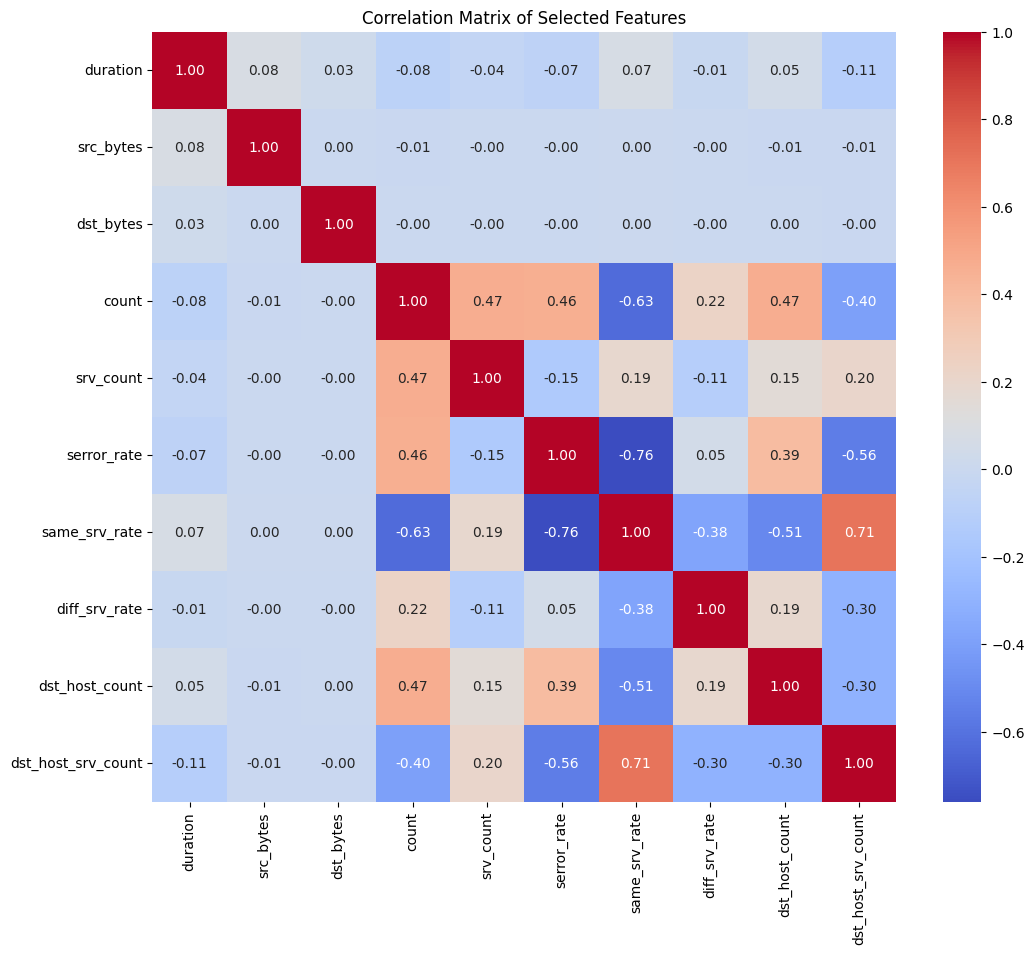

In [21]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Load data locally for demonstration
df_train = pd.read_csv("../data/train_set.csv")

# Create in-memory SQLite database
conn = sqlite3.connect(':memory:')
df_train.to_sql('traffic', conn, index=False)

# --- Query 1: Class Distribution ---
query_class = "SELECT label, COUNT(*) as count FROM traffic GROUP BY label ORDER BY count DESC"
df_class = pd.read_sql(query_class, conn)

# --- Query 2: Protocol Distribution ---
query_proto = "SELECT protocol_type, COUNT(*) as count FROM traffic GROUP BY protocol_type ORDER BY count DESC"
df_proto = pd.read_sql(query_proto, conn)

# --- Query 3: Attack vs Normal by Protocol ---
query_attack_proto = """
SELECT 
    protocol_type,
    CASE WHEN label = 'normal' THEN 'normal' ELSE 'attack' END as traffic_type,
    COUNT(*) as count
FROM traffic
GROUP BY protocol_type, traffic_type
"""
df_attack_proto = pd.read_sql(query_attack_proto, conn)

# --- Query 4: Average Duration per Label (Top 10) ---
query_duration = "SELECT label, AVG(duration) as avg_duration FROM traffic GROUP BY label ORDER BY avg_duration DESC LIMIT 10"
df_duration = pd.read_sql(query_duration, conn)

# --- Visualization ---
plt.figure(figsize=(15, 10))

# Plot 1: Class Distribution (Top 10 classes)
plt.subplot(2, 2, 1)
sns.barplot(data=df_class, x='count', y='label', palette='viridis')
plt.title('Top 10 Traffic Classes')

# Plot 2: Protocol Distribution
plt.subplot(2, 2, 2)
# Pie chart needs valid values
plt.pie(df_proto['count'], labels=df_proto['protocol_type'], autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Protocol Distribution')

# Plot 3: Attack vs Normal by Protocol
plt.subplot(2, 2, 3)
sns.barplot(data=df_attack_proto, x='protocol_type', y='count', hue='traffic_type', palette='Set1')
plt.title('Normal vs Attack by Protocol')
plt.yscale('log') # Log scale because counts vary widely

# Plot 4: Average Duration
plt.subplot(2, 2, 4)
sns.barplot(data=df_duration, x='avg_duration', y='label', palette='magma')
plt.title('Avg Duration by Label (Top 10)')

plt.tight_layout()
plt.savefig('eda_plots.png')

# --- Correlation Matrix (Pandas) ---
numeric_cols = df_train.select_dtypes(include=['number']).columns
# Filter constant columns
numeric_cols = [c for c in numeric_cols if df_train[c].std() > 0] 

plt.figure(figsize=(12, 10))
important_features = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count', 'serror_rate', 'same_srv_rate', 'diff_srv_rate', 'dst_host_count', 'dst_host_srv_count']
# Ensure these columns exist
important_features = [f for f in important_features if f in df_train.columns]

sns.heatmap(df_train[important_features].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Selected Features')
plt.savefig('correlation_matrix.png')

print("EDA plots generated.")

In [ ]:
import pandas as pd
from sqlalchemy import create_engine, inspect, text
from dotenv import load_dotenv
import os

# 1. Setup Connection
load_dotenv()

# Verify variables are loaded (Print them to check - hide password)
print(f"Connecting to DB: {os.getenv('POSTGRES_DB')} at {os.getenv('POSTGRES_HOST')}")

user = os.getenv("POSTGRES_USER")
password = os.getenv("POSTGRES_PASSWORD")
host = os.getenv("POSTGRES_HOST")
port = os.getenv("POSTGRES_PORT")
db = os.getenv("POSTGRES_DB")

# Connect
connection_str = f"postgresql://{user}:{password}@{host}:{port}/{db}"
engine = create_engine(connection_str)

# 2. Load Data
train_df = pd.read_csv("../data/train_set.csv") # Double check this path!
# Ensure no extra columns (like 'is_attack') that don't exist in SQL
if 'is_attack' in train_df.columns:
    train_df = train_df.drop(columns=['is_attack'])

print(f"Dataframe Shape: {train_df.shape}")

# 3. Insert Data (Force 'replace' to ensure it writes fresh)
# if_exists='replace' will DROP the table if it exists and create a new one
# method='multi' speeds up insertion
try:
    rows_affected = train_df.to_sql(
        "traffic", 
        engine, 
        if_exists="replace",  # CHANGED to 'replace' to ensure creation
        index=False, 
        method='multi',       # Faster insert
        chunksize=5000        # Process in batches
    )
    print(f"inserted rows (approx): {len(train_df)}")
except Exception as e:
    print(f"Error during insertion: {e}")

# 4. Verify Immediately (Source of Truth)
inspector = inspect(engine)
tables = inspector.get_table_names()
print(f"\nTables in Database '{db}': {tables}")

if 'traffic' in tables:
    with engine.connect() as conn:
        result = conn.execute(text("SELECT COUNT(*) FROM traffic"))
        count = result.scalar()
        print(f"Rows in 'traffic' table: {count}")
else:
    print("Table 'traffic' was NOT created.")

Connecting to DB: network_anomaly at localhost
Dataframe Shape: (88181, 43)
✅ inserted rows (approx): 88181

📂 Tables in Database 'network_anomaly': ['traffic']
📊 Rows in 'traffic' table: 88181


Connected to PostgreSQL!


C:\Users\HP\AppData\Local\Temp\ipykernel_23684\1615200919.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_class, x='count', y='label', palette='viridis')
C:\Users\HP\AppData\Local\Temp\ipykernel_23684\1615200919.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_duration, x='avg_duration', y='label', palette='magma')


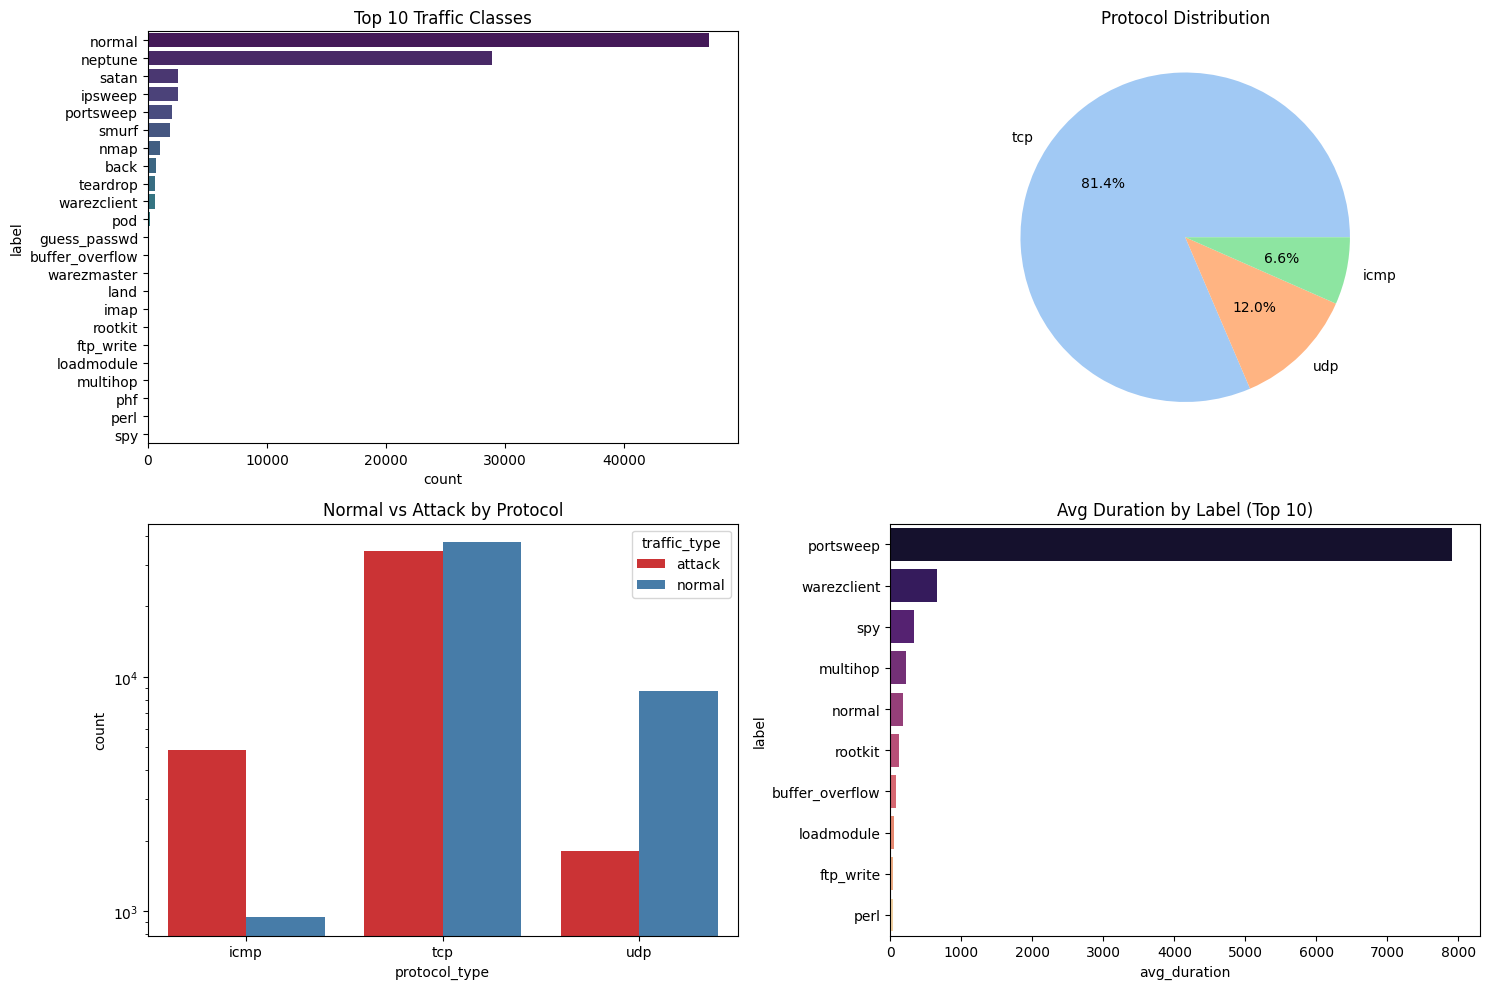

Fetching data for correlation matrix...


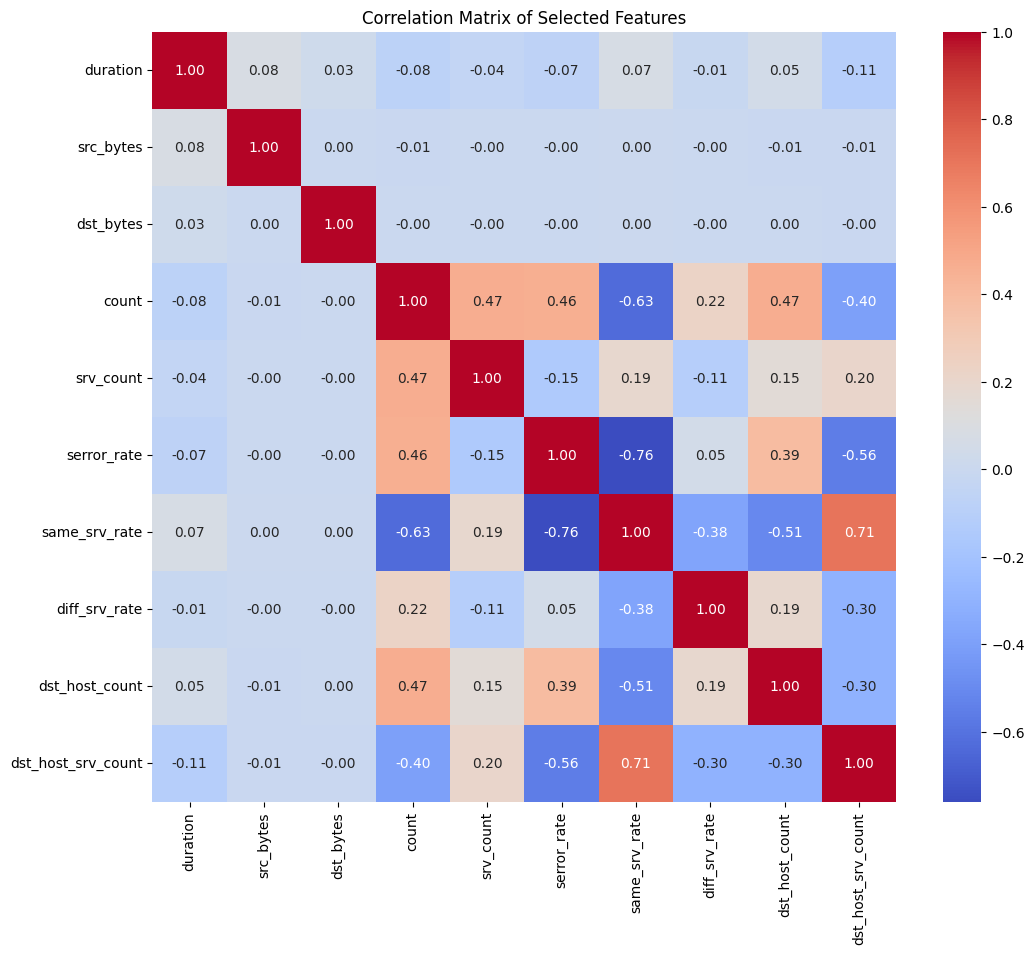

EDA completed using PostgreSQL data.


In [26]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv

output_dir = '../results'
# 1. Connect to your PostgreSQL Database
load_dotenv() # Load variables from .env file

user = os.getenv("POSTGRES_USER")
password = os.getenv("POSTGRES_PASSWORD")
host = os.getenv("POSTGRES_HOST")
port = os.getenv("POSTGRES_PORT")
db = os.getenv("POSTGRES_DB")

# Create connection engine
engine = create_engine(f"postgresql://{user}:{password}@{host}:{port}/{db}")
connection = engine.connect()

print("Connected to PostgreSQL!")

# --- Query 1: Class Distribution ---
query_class = """
SELECT label, COUNT(*) as count 
FROM traffic 
GROUP BY label 
ORDER BY count DESC
"""
df_class = pd.read_sql(query_class, connection)

# --- Query 2: Protocol Distribution ---
query_proto = """
SELECT protocol_type, COUNT(*) as count 
FROM traffic 
GROUP BY protocol_type 
ORDER BY count DESC
"""
df_proto = pd.read_sql(query_proto, connection)

# --- Query 3: Attack vs Normal by Protocol ---
query_attack_proto = """
SELECT 
    protocol_type,
    CASE WHEN label = 'normal' THEN 'normal' ELSE 'attack' END as traffic_type,
    COUNT(*) as count
FROM traffic
GROUP BY protocol_type, traffic_type
"""
df_attack_proto = pd.read_sql(query_attack_proto, connection)

# --- Query 4: Average Duration per Label (Top 10) ---
# Note: In Postgres, AVG() on integers returns Numeric, so we cast to FLOAT for Pandas safety
query_duration = """
SELECT label, AVG(duration)::FLOAT as avg_duration 
FROM traffic 
GROUP BY label 
ORDER BY avg_duration DESC 
LIMIT 10
"""
df_duration = pd.read_sql(query_duration, connection)

# --- Visualization (Same as before) ---
plt.figure(figsize=(15, 10))

# Plot 1: Class Distribution (Top 10 classes)
plt.subplot(2, 2, 1)
sns.barplot(data=df_class, x='count', y='label', palette='viridis')
plt.title('Top 10 Traffic Classes')

# Plot 2: Protocol Distribution
plt.subplot(2, 2, 2)
plt.pie(df_proto['count'], labels=df_proto['protocol_type'], autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Protocol Distribution')

# Plot 3: Attack vs Normal by Protocol
plt.subplot(2, 2, 3)
sns.barplot(data=df_attack_proto, x='protocol_type', y='count', hue='traffic_type', palette='Set1')
plt.title('Normal vs Attack by Protocol')
plt.yscale('log') # Log scale is crucial here

# Plot 4: Average Duration
plt.subplot(2, 2, 4)
sns.barplot(data=df_duration, x='avg_duration', y='label', palette='magma')
plt.title('Avg Duration by Label (Top 10)')

plt.tight_layout()

plt.savefig(os.path.join(output_dir, "eda_overview.png"), dpi=300, bbox_inches="tight")
plt.show()
# --- Correlation Matrix ---
# Fetch only numeric columns needed for correlation from DB
# Fetching 88k rows is fine for local memory
print("Fetching data for correlation matrix...")
query_corr = """
SELECT duration, src_bytes, dst_bytes, count, srv_count, 
       serror_rate, same_srv_rate, diff_srv_rate, 
       dst_host_count, dst_host_srv_count 
FROM traffic
"""
df_corr = pd.read_sql(query_corr, connection)

plt.figure(figsize=(12, 10))
sns.heatmap(df_corr.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Selected Features')
plt.savefig(os.path.join(output_dir, "correlation_matrix.png"),
            dpi=300,
            bbox_inches="tight")
plt.show()


print("EDA completed using PostgreSQL data.")